In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier

In [70]:
train_data = pd.read_csv('data/preprocessed_data_2.csv', delimiter=';')
print(train_data.dtypes)

hour_of_day              float64
weekday                    int64
summertime                 int64
temp                     float64
dew                      float64
humidity                 float64
precip                   float64
snowdepth                float64
windspeed                float64
cloudcover               float64
visibility               float64
increase_stock             int64
day_of_week_0              int64
day_of_week_1              int64
day_of_week_2              int64
day_of_week_3              int64
day_of_week_4              int64
day_of_week_5              int64
day_of_week_6              int64
month_1                    int64
month_2                    int64
month_3                    int64
month_4                    int64
month_5                    int64
month_6                    int64
month_7                    int64
month_8                    int64
month_9                    int64
month_10                   int64
month_11                   int64
month_12  

In [71]:
# categorical_features = ['weekday','summertime','increase_stock']
# #'weekday','month','hour_of_day', 'day_of_week' ? these make the performance worse as categorical values..
# for feature in categorical_features:
#     train_data[feature] = train_data[feature].astype('category')

# # Check the updated data types
# print(train_data.dtypes)


In [72]:
X = train_data.drop('increase_stock', axis=1)
y = train_data['increase_stock']

print(X.shape)
print(y.shape)

(1600, 33)
(1600,)


In [73]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
#train model
xgb_model = xgb.XGBClassifier(
    random_state=0,
    enable_categorical = True
)
print(np.unique(y))
print(y.tail())
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

[0 1]
1595    0
1596    0
1597    0
1598    1
1599    0
Name: increase_stock, dtype: int64


In [75]:
#check performance 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.87
Precision: 0.64
Recall: 0.62
F1-Score: 0.63
Confusion Matrix: 
[[242  20]
 [ 22  36]]


In [76]:
#find best hyper parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [7, 10,12],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'n_estimators': [10, 20, 30], 
    'min_child_weight':[0.1, 1, 3],
    'gamma':[0, 0.1, 0.3],
    'reg_alpha':[ 0.1, 1, 2],
    'reg_lambda': [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=0, enable_categorical = True),
    param_grid=param_grid,
    scoring='accuracy',  # RECALL OR ????
    cv=4, 
    verbose=1,
    n_jobs = -1
)

grid_search.fit(X_train, y_train,)
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Fitting 4 folds for each of 1944 candidates, totalling 7776 fits
Best parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10, 'reg_alpha': 2, 'reg_lambda': 0}
Best recall: 0.91875


In [77]:
final_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=0, enable_categorical=True)

In [78]:
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.89
Precision: 0.72
Recall: 0.62
F1-Score: 0.67
Confusion Matrix: 
[[248  14]
 [ 22  36]]


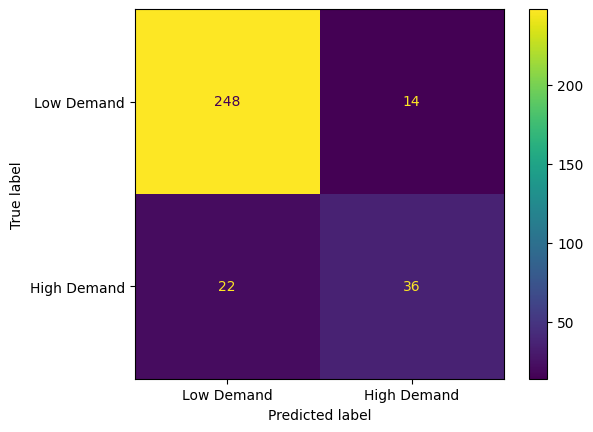

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Demand', 'High Demand'])
disp.plot()

In [80]:
final_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=0, enable_categorical=True)

In [81]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

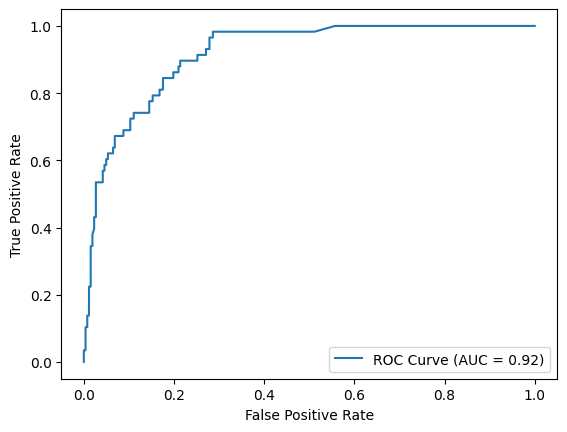

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = final_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [83]:
import utils


param_grid = {
    'max_depth': [7, 10, 12],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'n_estimators': [10, 20, 30], 
    'min_child_weight':[0.1, 1, 3],
    'gamma':[0, 0.1, 0.3],
    'reg_alpha':[ 0.1, 1, 2],
    'reg_lambda': [0, 0.1]
}

extra_args = {
    'random_state': 0,
    'enable_categorical': True
}

utils.find_optimal_hyperparameters(XGBClassifier, param_grid, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, save_dir="output/best_params", save_file='xgb_best_params.json', extra_args=extra_args)


Best parameters found:  {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10, 'reg_alpha': 1, 'reg_lambda': 0.1}
Saving best parameters to 'output/best_params/xgb_best_params.json'


{'gamma': 0.1,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 10,
 'reg_alpha': 1,
 'reg_lambda': 0.1,
 'random_state': 0,
 'enable_categorical': True}

In [84]:
import utils


model = utils.load_model_from_json(XGBClassifier, "output/best_params/xgb_best_params.json")

_ = utils.fit_and_evaluate(model, 
                                                           X_train, 
                                                           y_train, 
                                                           X_test, 
                                                           y_test, 
                                                           verbose=True)


                                                        

Evaluating XGBClassifier
Accuracy: 0.8812
Precision: 0.7000
Recall: 0.6034
F1: 0.6481
ROC AUC: 0.9158
Confusion Matrix: 
[[247  15]
 [ 23  35]]

